In [1]:
import sys
sys.path.insert(0, '/home/cscadmin/CyberResearch/CAT-Transformer/model/')
from updatedModel import CATTransformer, Combined_Dataset, train, test
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState

/home/cscadmin/miniconda3/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [4]:
# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\helena\validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/train.csv')
# df_test = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/test.csv')
# df_val = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/helena/validation.csv')


df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/helena/validation.csv')


# df_train.columns
cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

target classes [100]


# RUN EXPERIMENTS

1. Using Optuna to optimize CAT-Transformers hyperparameters for your dataset

In [5]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over

    alpha = trial.suggest_float('alpha', 0.1, 5, step=0.1)
    embed_size = trial.suggest_int('embed_size', 100, 320, step=20)
    num_layers = trial.suggest_int('num_layers', 1,2)
    heads = trial.suggest_categorical('heads', [1,2,5,10,20])
    forward_expansion = trial.suggest_int('forward_expansion', 2,8)
    decoder_dropout = trial.suggest_float('decoder_dropout', 0, .5, step=.1)
    classification_dropout = trial.suggest_float('classificiation_dropout', 0, 0.5, step=0.1)
    pre_norm_on = trial.suggest_categorical('pre_norm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 2, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.1, log=True)

    num_epochs = 100


    # Create your model with the sampled hyperparameters
    model = CATTransformer(alpha=alpha,
                           embed_size=embed_size,
                           n_cont=len(cont_columns),
                           cat_feat=[],
                           num_layers=num_layers,
                           heads=heads,
                           forward_expansion=forward_expansion,
                           decoder_dropout=decoder_dropout,
                           classification_dropout=classification_dropout,
                           pre_norm_on=pre_norm_on,
                           mlp_scale_classification=mlp_scale_classification,
                           regression_on=False,
                           targets_classes=target_classes).to(device_in_use)

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
        val_loss, val_acc = test(regression_on=False,
                               dataloader=val_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_acc):
            break
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_acc:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_acc

In [6]:
# Set the number of optimization trials
num_trials = 50

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

[I 2023-12-03 21:38:41,082] A new study created in memory with name: no-name-833634f7-15b0-44dc-9800-23d9b267b04a
Best trial: 0. Best value: 0.0595153:   2%|▏         | 1/50 [07:14<5:54:44, 434.38s/it]

[I 2023-12-03 21:45:55,463] Trial 0 finished with value: 0.05951528786174456 and parameters: {'alpha': 2.1, 'embed_size': 260, 'num_layers': 1, 'heads': 1, 'forward_expansion': 8, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': False, 'mlp_scale_classification': 6, 'learning_rate': 0.0009529101776362234}. Best is trial 0 with value: 0.05951528786174456.


Best trial: 1. Best value: 0.178137:   4%|▍         | 2/50 [14:35<5:50:31, 438.15s/it] 

[I 2023-12-03 21:53:16,255] Trial 1 finished with value: 0.17813682380611515 and parameters: {'alpha': 4.2, 'embed_size': 160, 'num_layers': 1, 'heads': 2, 'forward_expansion': 2, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.001436091622596107}. Best is trial 1 with value: 0.17813682380611515.


Best trial: 2. Best value: 0.198487:   6%|▌         | 3/50 [22:02<5:46:26, 442.27s/it]

[I 2023-12-03 22:00:43,428] Trial 2 finished with value: 0.1984865528172615 and parameters: {'alpha': 0.2, 'embed_size': 120, 'num_layers': 2, 'heads': 1, 'forward_expansion': 6, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.1, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 0.0007296000591897836}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 2. Best value: 0.198487:   8%|▊         | 4/50 [29:18<5:37:22, 440.05s/it]

[I 2023-12-03 22:08:00,078] Trial 3 finished with value: 0.13457408732999285 and parameters: {'alpha': 4.0, 'embed_size': 260, 'num_layers': 1, 'heads': 20, 'forward_expansion': 5, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.4, 'pre_norm_on': False, 'mlp_scale_classification': 2, 'learning_rate': 2.0762602578884446e-05}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 2. Best value: 0.198487:  10%|█         | 5/50 [36:27<5:26:47, 435.71s/it]

[I 2023-12-03 22:15:08,101] Trial 4 finished with value: 0.19224869618570406 and parameters: {'alpha': 3.5000000000000004, 'embed_size': 280, 'num_layers': 1, 'heads': 10, 'forward_expansion': 3, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.1, 'pre_norm_on': False, 'mlp_scale_classification': 2, 'learning_rate': 0.00011566830457013527}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 2. Best value: 0.198487:  12%|█▏        | 6/50 [43:52<5:21:59, 439.08s/it]

[I 2023-12-03 22:22:33,719] Trial 5 finished with value: 0.1611616729726966 and parameters: {'alpha': 3.2, 'embed_size': 120, 'num_layers': 2, 'heads': 1, 'forward_expansion': 4, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': False, 'mlp_scale_classification': 6, 'learning_rate': 4.6051080241159945e-05}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 2. Best value: 0.198487:  14%|█▍        | 7/50 [51:18<5:16:17, 441.33s/it]

[I 2023-12-03 22:29:59,687] Trial 6 finished with value: 0.16739952960425403 and parameters: {'alpha': 3.1, 'embed_size': 320, 'num_layers': 1, 'heads': 5, 'forward_expansion': 5, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.1, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 0.00010385752116457836}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 2. Best value: 0.198487:  16%|█▌        | 8/50 [58:33<5:07:34, 439.39s/it]

[I 2023-12-03 22:37:14,929] Trial 7 finished with value: 0.14316392269148176 and parameters: {'alpha': 4.8, 'embed_size': 100, 'num_layers': 1, 'heads': 1, 'forward_expansion': 7, 'decoder_dropout': 0.5, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 5.3482338706294464e-05}. Best is trial 2 with value: 0.1984865528172615.


Best trial: 8. Best value: 0.205645:  18%|█▊        | 9/50 [1:06:19<5:05:55, 447.69s/it]

[I 2023-12-03 22:45:00,866] Trial 8 finished with value: 0.20564474895183557 and parameters: {'alpha': 3.0000000000000004, 'embed_size': 260, 'num_layers': 2, 'heads': 5, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 7.159074097620244e-05}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  20%|██        | 10/50 [1:13:31<4:55:13, 442.84s/it]

[I 2023-12-03 22:52:12,832] Trial 9 finished with value: 0.15942325391144288 and parameters: {'alpha': 0.4, 'embed_size': 180, 'num_layers': 1, 'heads': 5, 'forward_expansion': 7, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': False, 'mlp_scale_classification': 2, 'learning_rate': 2.9063166346033356e-05}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  22%|██▏       | 11/50 [1:21:20<4:53:04, 450.89s/it]

[I 2023-12-03 23:00:01,995] Trial 10 finished with value: 0.05869720830350752 and parameters: {'alpha': 1.7000000000000002, 'embed_size': 220, 'num_layers': 2, 'heads': 5, 'forward_expansion': 8, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.07235591567032836}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  24%|██▍       | 12/50 [1:29:02<4:47:33, 454.04s/it]

[I 2023-12-03 23:07:43,232] Trial 11 finished with value: 0.15737805501585028 and parameters: {'alpha': 0.1, 'embed_size': 200, 'num_layers': 2, 'heads': 2, 'forward_expansion': 6, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.0, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.0006129036904236925}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  26%|██▌       | 13/50 [1:36:47<4:42:08, 457.54s/it]

[I 2023-12-03 23:15:28,825] Trial 12 finished with value: 0.14224358318846508 and parameters: {'alpha': 1.1, 'embed_size': 140, 'num_layers': 2, 'heads': 20, 'forward_expansion': 6, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.1, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 1.1290106567762538e-05}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  28%|██▊       | 14/50 [1:44:27<4:34:50, 458.07s/it]

[I 2023-12-03 23:23:08,125] Trial 13 finished with value: 0.17885264341957255 and parameters: {'alpha': 2.4000000000000004, 'embed_size': 220, 'num_layers': 2, 'heads': 10, 'forward_expansion': 6, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.2, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 0.0002645512118646647}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  30%|███       | 15/50 [1:51:59<4:26:08, 456.23s/it]

[I 2023-12-03 23:30:40,087] Trial 14 finished with value: 0.10543000306779834 and parameters: {'alpha': 1.4000000000000001, 'embed_size': 320, 'num_layers': 2, 'heads': 5, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.0, 'pre_norm_on': False, 'mlp_scale_classification': 5, 'learning_rate': 0.00495524547888603}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  32%|███▏      | 16/50 [1:59:48<4:20:44, 460.13s/it]

[I 2023-12-03 23:38:29,279] Trial 15 finished with value: 0.19143061662746702 and parameters: {'alpha': 2.7, 'embed_size': 280, 'num_layers': 2, 'heads': 1, 'forward_expansion': 7, 'decoder_dropout': 0.30000000000000004, 'classificiation_dropout': 0.2, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.00023990642819153671}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  34%|███▍      | 17/50 [2:07:34<4:14:08, 462.07s/it]

[I 2023-12-03 23:46:15,869] Trial 16 finished with value: 0.19327129563350035 and parameters: {'alpha': 0.8, 'embed_size': 240, 'num_layers': 2, 'heads': 5, 'forward_expansion': 4, 'decoder_dropout': 0.4, 'classificiation_dropout': 0.2, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.002890617526382663}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  36%|███▌      | 18/50 [2:15:02<4:04:09, 457.81s/it]

[I 2023-12-03 23:53:43,758] Trial 17 finished with value: 0.1309949892627058 and parameters: {'alpha': 1.9000000000000001, 'embed_size': 180, 'num_layers': 2, 'heads': 1, 'forward_expansion': 6, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': False, 'mlp_scale_classification': 8, 'learning_rate': 1.1371057925550409e-05}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 8. Best value: 0.205645:  38%|███▊      | 19/50 [2:22:36<3:55:53, 456.57s/it]

[I 2023-12-04 00:01:17,450] Trial 18 finished with value: 0.20513344922793741 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 100, 'num_layers': 2, 'heads': 20, 'forward_expansion': 5, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.1, 'pre_norm_on': False, 'mlp_scale_classification': 3, 'learning_rate': 0.0002576818495223017}. Best is trial 8 with value: 0.20564474895183557.


Best trial: 19. Best value: 0.214848:  40%|████      | 20/50 [2:30:21<3:49:34, 459.16s/it]

[I 2023-12-04 00:09:02,635] Trial 19 finished with value: 0.21484814398200225 and parameters: {'alpha': 2.8000000000000003, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 9.916654074254129e-05}. Best is trial 19 with value: 0.21484814398200225.


Best trial: 19. Best value: 0.214848:  42%|████▏     | 21/50 [2:38:08<3:43:00, 461.39s/it]

[I 2023-12-04 00:16:49,223] Trial 20 finished with value: 0.2125984251968504 and parameters: {'alpha': 3.9000000000000004, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 7.910790137565525e-05}. Best is trial 19 with value: 0.21484814398200225.


Best trial: 19. Best value: 0.214848:  44%|████▍     | 22/50 [2:45:50<3:35:25, 461.63s/it]

[I 2023-12-04 00:24:31,423] Trial 21 finished with value: 0.19777073320380406 and parameters: {'alpha': 3.9000000000000004, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 4.6280859347429124e-05}. Best is trial 19 with value: 0.21484814398200225.


Best trial: 22. Best value: 0.216791:  46%|████▌     | 23/50 [2:53:43<3:29:18, 465.12s/it]

[I 2023-12-04 00:32:24,679] Trial 22 finished with value: 0.2167910829328152 and parameters: {'alpha': 4.6, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 9.662984046505598e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  48%|████▊     | 24/50 [3:01:28<3:21:35, 465.20s/it]

[I 2023-12-04 00:40:10,066] Trial 23 finished with value: 0.172103487064117 and parameters: {'alpha': 4.9, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 2.0522125373430514e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  50%|█████     | 25/50 [3:09:07<3:12:58, 463.16s/it]

[I 2023-12-04 00:47:48,452] Trial 24 finished with value: 0.19725943347990593 and parameters: {'alpha': 4.3999999999999995, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.0001383726824017234}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  52%|█████▏    | 26/50 [3:16:50<3:05:17, 463.24s/it]

[I 2023-12-04 00:55:31,889] Trial 25 finished with value: 0.21597300337457817 and parameters: {'alpha': 4.6, 'embed_size': 320, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.00015184134830873946}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  54%|█████▍    | 27/50 [3:24:35<2:57:43, 463.64s/it]

[I 2023-12-04 01:03:16,456] Trial 26 finished with value: 0.1869311790571633 and parameters: {'alpha': 4.5, 'embed_size': 320, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.00016957962294702396}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  56%|█████▌    | 28/50 [3:32:23<2:50:28, 464.92s/it]

[I 2023-12-04 01:11:04,358] Trial 27 finished with value: 0.18294304121075775 and parameters: {'alpha': 3.5000000000000004, 'embed_size': 280, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 3.340325945806249e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  58%|█████▊    | 29/50 [3:40:11<2:43:03, 465.90s/it]

[I 2023-12-04 01:18:52,538] Trial 28 finished with value: 0.20083853154719297 and parameters: {'alpha': 5.0, 'embed_size': 240, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 0.0003984790065010421}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  60%|██████    | 30/50 [3:47:54<2:35:03, 465.19s/it]

[I 2023-12-04 01:26:36,078] Trial 29 finished with value: 0.1769097044687596 and parameters: {'alpha': 2.4000000000000004, 'embed_size': 320, 'num_layers': 2, 'heads': 10, 'forward_expansion': 4, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00015546387993318214}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  62%|██████▏   | 31/50 [3:55:42<2:27:33, 465.98s/it]

[I 2023-12-04 01:34:23,918] Trial 30 finished with value: 0.20042949176807445 and parameters: {'alpha': 3.6, 'embed_size': 280, 'num_layers': 2, 'heads': 2, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 7.602830193386872e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  64%|██████▍   | 32/50 [4:03:24<2:19:24, 464.70s/it]

[I 2023-12-04 01:42:05,612] Trial 31 finished with value: 0.21372328458942633 and parameters: {'alpha': 4.6, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 7.684725263853323e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  66%|██████▌   | 33/50 [4:11:16<2:12:15, 466.82s/it]

[I 2023-12-04 01:49:57,381] Trial 32 finished with value: 0.21648430309847633 and parameters: {'alpha': 4.6, 'embed_size': 300, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 8.89072463619069e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  68%|██████▊   | 34/50 [4:19:06<2:04:44, 467.75s/it]

[I 2023-12-04 01:57:47,308] Trial 33 finished with value: 0.20083853154719297 and parameters: {'alpha': 4.2, 'embed_size': 260, 'num_layers': 2, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.00040029376957881167}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  70%|███████   | 35/50 [4:26:56<1:57:06, 468.45s/it]

[I 2023-12-04 02:05:37,378] Trial 34 finished with value: 0.2033950301666837 and parameters: {'alpha': 4.2, 'embed_size': 320, 'num_layers': 2, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.00012411701893589347}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  72%|███████▏  | 36/50 [4:34:17<1:47:24, 460.32s/it]

[I 2023-12-04 02:12:58,740] Trial 35 finished with value: 0.16197975253093364 and parameters: {'alpha': 4.7, 'embed_size': 280, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 2.3865396301256964e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  74%|███████▍  | 37/50 [4:42:02<1:40:00, 461.60s/it]

[I 2023-12-04 02:20:43,320] Trial 36 finished with value: 0.20871254729522445 and parameters: {'alpha': 3.8000000000000003, 'embed_size': 300, 'num_layers': 2, 'heads': 2, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 4.895901601048282e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  76%|███████▌  | 38/50 [4:49:42<1:32:14, 461.23s/it]

[I 2023-12-04 02:28:23,704] Trial 37 finished with value: 0.17977298292258923 and parameters: {'alpha': 4.3, 'embed_size': 240, 'num_layers': 2, 'heads': 20, 'forward_expansion': 4, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 3, 'learning_rate': 0.00102627718235159}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  78%|███████▊  | 39/50 [4:57:10<1:23:50, 457.31s/it]

[I 2023-12-04 02:35:51,862] Trial 38 finished with value: 0.2160752633193578 and parameters: {'alpha': 5.0, 'embed_size': 260, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.00010025092236715996}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  80%|████████  | 40/50 [5:04:32<1:15:27, 452.78s/it]

[I 2023-12-04 02:43:14,055] Trial 39 finished with value: 0.18866959811841702 and parameters: {'alpha': 5.0, 'embed_size': 260, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 3.965943741428902e-05}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  82%|████████▏ | 41/50 [5:11:58<1:07:34, 450.54s/it]

[I 2023-12-04 02:50:39,377] Trial 40 finished with value: 0.18427242049289294 and parameters: {'alpha': 4.7, 'embed_size': 280, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 0.00018748096256888667}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  84%|████████▍ | 42/50 [5:19:27<1:00:02, 450.27s/it]

[I 2023-12-04 02:58:09,011] Trial 41 finished with value: 0.21576848348501892 and parameters: {'alpha': 4.3999999999999995, 'embed_size': 320, 'num_layers': 1, 'heads': 20, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00011200991154207573}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 22. Best value: 0.216791:  86%|████████▌ | 43/50 [5:26:52<52:19, 448.50s/it]  

[I 2023-12-04 03:05:33,398] Trial 42 finished with value: 0.20983740668780038 and parameters: {'alpha': 4.5, 'embed_size': 320, 'num_layers': 1, 'heads': 20, 'forward_expansion': 4, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.5, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 0.00012156304121844645}. Best is trial 22 with value: 0.2167910829328152.


Best trial: 43. Best value: 0.217302:  88%|████████▊ | 44/50 [5:34:23<44:55, 449.22s/it]

[I 2023-12-04 03:13:04,302] Trial 43 finished with value: 0.21730238265671337 and parameters: {'alpha': 4.2, 'embed_size': 320, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 5.969008073055464e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302:  90%|█████████ | 45/50 [5:41:50<37:23, 448.73s/it]

[I 2023-12-04 03:20:31,882] Trial 44 finished with value: 0.20728090806830965 and parameters: {'alpha': 4.8, 'embed_size': 260, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 7, 'learning_rate': 7.018840308162283e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302:  92%|█████████▏| 46/50 [5:49:14<29:49, 447.31s/it]

[I 2023-12-04 03:27:55,891] Trial 45 finished with value: 0.21505266387156152 and parameters: {'alpha': 5.0, 'embed_size': 280, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 5.236225005750091e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302:  94%|█████████▍| 47/50 [5:56:35<22:16, 445.35s/it]

[I 2023-12-04 03:35:16,646] Trial 46 finished with value: 0.2012475713263115 and parameters: {'alpha': 4.1, 'embed_size': 320, 'num_layers': 1, 'heads': 2, 'forward_expansion': 2, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 2, 'learning_rate': 1.9427379866387307e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302:  96%|█████████▌| 48/50 [6:03:49<14:44, 442.02s/it]

[I 2023-12-04 03:42:30,908] Trial 47 finished with value: 0.1841701605481133 and parameters: {'alpha': 3.3000000000000003, 'embed_size': 300, 'num_layers': 1, 'heads': 1, 'forward_expansion': 3, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': False, 'mlp_scale_classification': 7, 'learning_rate': 2.9502293852705687e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302:  98%|█████████▊| 49/50 [6:11:22<07:25, 445.28s/it]

[I 2023-12-04 03:50:03,787] Trial 48 finished with value: 0.20799672768176705 and parameters: {'alpha': 3.7, 'embed_size': 320, 'num_layers': 1, 'heads': 10, 'forward_expansion': 2, 'decoder_dropout': 0.2, 'classificiation_dropout': 0.30000000000000004, 'pre_norm_on': True, 'mlp_scale_classification': 5, 'learning_rate': 6.555528805814662e-05}. Best is trial 43 with value: 0.21730238265671337.


Best trial: 43. Best value: 0.217302: 100%|██████████| 50/50 [6:18:45<00:00, 454.52s/it]

[I 2023-12-04 03:57:26,899] Trial 49 finished with value: 0.17905716330913182 and parameters: {'alpha': 4.0, 'embed_size': 260, 'num_layers': 1, 'heads': 20, 'forward_expansion': 5, 'decoder_dropout': 0.0, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 4, 'learning_rate': 0.00020400011972463317}. Best is trial 43 with value: 0.21730238265671337.
Best Hyperparameters: {'alpha': 4.2, 'embed_size': 320, 'num_layers': 1, 'heads': 20, 'forward_expansion': 2, 'decoder_dropout': 0.1, 'classificiation_dropout': 0.4, 'pre_norm_on': True, 'mlp_scale_classification': 6, 'learning_rate': 5.969008073055464e-05}
Best Validation Accuracy (at Early Stopping): 0.21730238265671337


Epoch [ 1/100]  | Train: Loss 4.284565851009092, Accuracy 0.0525889081227951        | Test: Loss 4.120020157251602, Accuracy 0.08292433537832311       
Epoch [ 2/100]  | Train: Loss 4.096100490186467, Accuracy 0.0852378552490304        | Test: Loss 3.954211467351669, Accuracy 0.1149284253578732        
Epoch [ 3/100]  | Train: Loss 3.9736705439050772, Accuracy 0.11023949865240923      | Test: Loss 3.8846280452532644, Accuracy 0.12576687116564417      
Epoch [ 4/100]  | Train: Loss 3.925480903859911, Accuracy 0.11758003374454938       | Test: Loss 3.8569679871583595, Accuracy 0.13047034764826176      
Epoch [ 5/100]  | Train: Loss 3.8958438508337436, Accuracy 0.11963976597935885      | Test: Loss 3.8403975474528775, Accuracy 0.13650306748466257      
Epoch [ 6/100]  | Train: Loss 3.871533540374074, Accuracy 0.12478909656638254       | Test: Loss 3.8180032265491977, Accuracy 0.13732106339468303      
Epoch [ 7/100]  | Train: Loss 3.845321895023964, Accuracy 0.12726515765716415       | Te

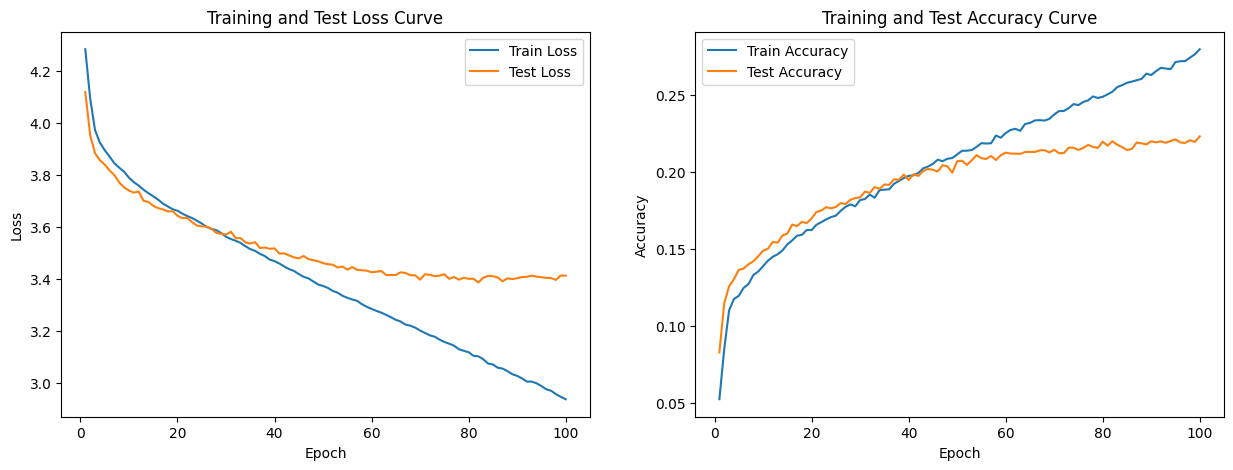

In [7]:
#Testing against the test dataset

model = CATTransformer(alpha=best_params['alpha'],
                           embed_size=best_params['embed_size'],
                           n_cont=len(cont_columns),
                           cat_feat=[],
                           num_layers=best_params['num_layers'],
                           heads=best_params['heads'],
                           forward_expansion=best_params['forward_expansion'],
                           decoder_dropout=best_params['decoder_dropout'],
                           classification_dropout=best_params['classificiation_dropout'],
                           pre_norm_on=best_params['pre_norm_on'],
                           mlp_scale_classification=best_params['mlp_scale_classification'],
                           regression_on=False,
                           targets_classes=target_classes).to(device_in_use)
loss_functions = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
early_stopping = EarlyStopping(patience=5)
epochs = 100 

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

for t in range(epochs):
    train_loss, train_acc = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_functions, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc = test(regression_on=False,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_functions,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}\n",file=open("log_2pi.txt", 'a'))
